In [1]:
import numpy as np 
import pandas as pd
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from colorama import Fore
import os

In [2]:
base_path = "Knee Osteoarthritis Classification/train"
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [3]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)  

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [4]:
df.head()

,image_path,label
0,Knee Osteoarthritis Classification/train\Norma...,Normal
1,Knee Osteoarthritis Classification/train\Norma...,Normal
2,Knee Osteoarthritis Classification/train\Norma...,Normal
3,Knee Osteoarthritis Classification/train\Norma...,Normal
4,Knee Osteoarthritis Classification/train\Norma...,Normal


In [5]:
df.tail()

,image_path,label
3775,Knee Osteoarthritis Classification/train\Osteo...,Osteoporosis
3776,Knee Osteoarthritis Classification/train\Osteo...,Osteoporosis
3777,Knee Osteoarthritis Classification/train\Osteo...,Osteoporosis
3778,Knee Osteoarthritis Classification/train\Osteo...,Osteoporosis
3779,Knee Osteoarthritis Classification/train\Osteo...,Osteoporosis


In [6]:
df.shape

(3780, 2)

In [7]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3780 non-null   object
 1   label       3780 non-null   object
dtypes: object(2)
memory usage: 59.2+ KB


In [11]:
df['label'].unique()

array(['Normal', 'Osteopenia', 'Osteoporosis'], dtype=object)

In [12]:
df['label'].value_counts()

label
Normal          1260
Osteopenia      1260
Osteoporosis    1260
Name: count, dtype: int64

In [13]:
df.describe()

,image_path,label
count,3780,3780
unique,3780,3
top,Knee Osteoarthritis Classification/train\Norma...,Normal
freq,1,1260


C:\Users\HP\AppData\Local\Temp\ipykernel_27348\2091214670.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set2", ax=ax)


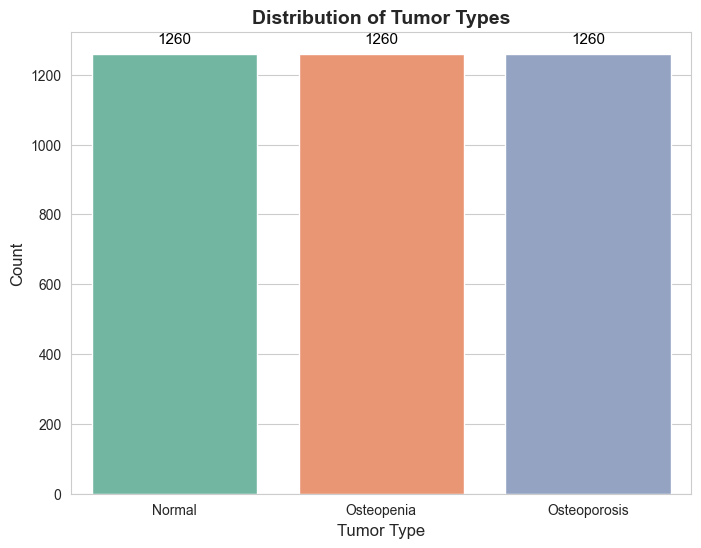

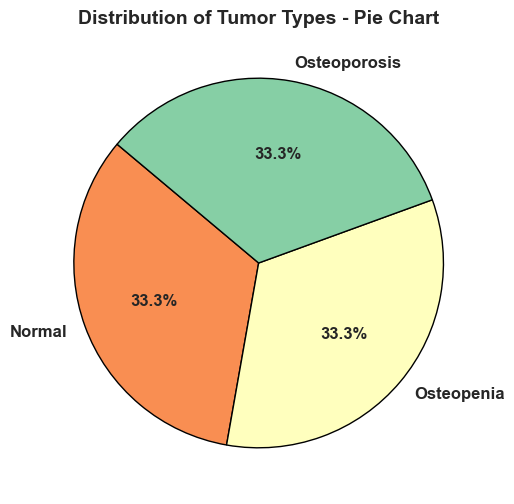

In [14]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="Set2", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("Spectral", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

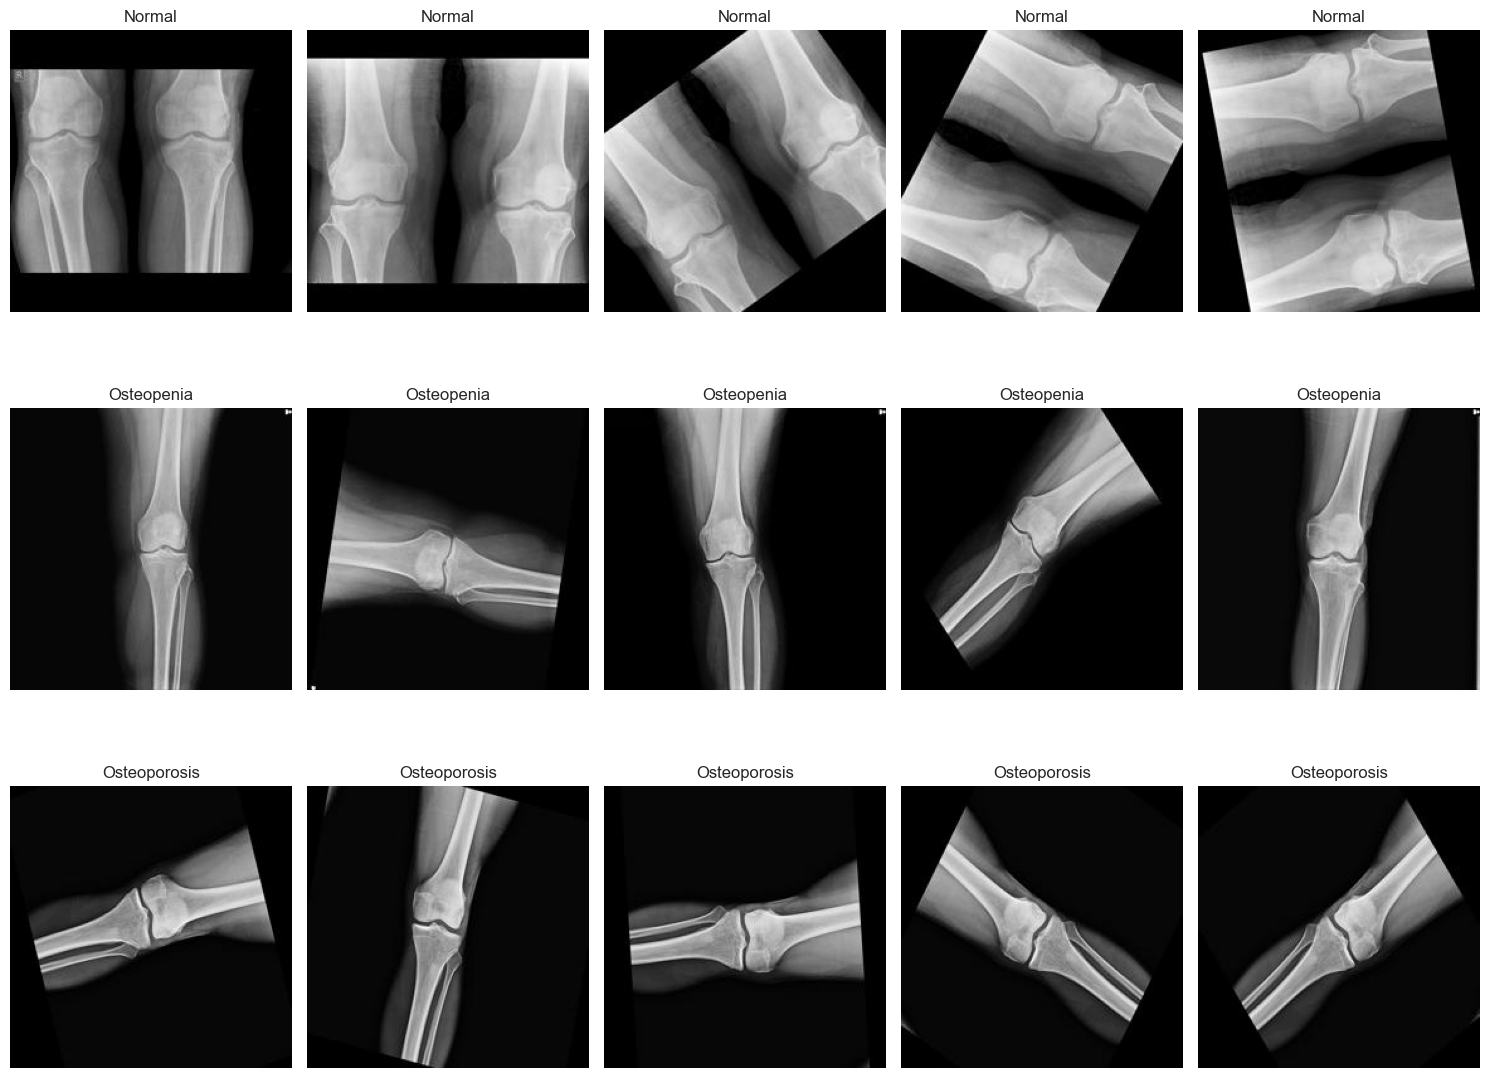

In [15]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [17]:
df = df[['image_path', 'category_encoded']]

In [18]:
from imblearn.over_sampling import RandomOverSampler

In [19]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

In [20]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled

In [21]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    1260
1    1260
2    1260
Name: count, dtype: int64


In [22]:
df_resampled

,image_path,category_encoded
0,Knee Osteoarthritis Classification/train\Norma...,0
1,Knee Osteoarthritis Classification/train\Norma...,0
2,Knee Osteoarthritis Classification/train\Norma...,0
3,Knee Osteoarthritis Classification/train\Norma...,0
4,Knee Osteoarthritis Classification/train\Norma...,0
...,...,...
3775,Knee Osteoarthritis Classification/train\Osteo...,2
3776,Knee Osteoarthritis Classification/train\Osteo...,2
3777,Knee Osteoarthritis Classification/train\Osteo...,2
3778,Knee Osteoarthritis Classification/train\Osteo...,2


In [23]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [24]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)

In [25]:
batch_size = 16
img_size = (224, 224)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',  
    y_col='category_encoded',     
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path', 
    y_col='category_encoded',    
    target_size=img_size,
    class_mode='sparse',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 3024 validated image filenames belonging to 3 classes.
Found 378 validated image filenames belonging to 3 classes.
Found 378 validated image filenames belonging to 3 classes.


In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [27]:
 gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, GaussianNoise, MultiHeadAttention, Reshape
)
from tensorflow.keras.optimizers import Adam

In [31]:
def create_xception_model(input_shape, num_classes=8, learning_rate=1e-4):
    inputs = Input(shape=input_shape, name="Input_Layer")

    base_model = Xception(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = False  

    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    x = Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    x = Reshape((height, width, channels), name="Reshape_to_Spatial")(x)

    x = GaussianNoise(0.25, name="Gaussian_Noise")(x)

    x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = Dense(512, activation="relu", name="FC_512")(x)
    x = BatchNormalization(name="Batch_Normalization")(x)
    x = Dropout(0.25, name="Dropout")(x)

    outputs = Dense(num_classes, activation="softmax", name="Output_Layer")(x)
    model = Model(inputs=inputs, outputs=outputs, name="Xception_with_Attention")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape, num_classes=3, learning_rate=1e-4)

In [60]:
cnn_model.summary()

Model: "MobileNet_with_Attention_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ Input_Layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 105,948,555 (404.16 MB)

 Trainable params: 34,239,555 (130.61 MB)

 Non-trainable params: 3,229,888 (12.32 MB)

 Optimizer params: 68,479,112 (261.23 MB)

In [32]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2  
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    prob_ratio = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1) / (
        tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1) + 1e-10
    )
    clipped_ratio = tf.clip_by_value(prob_ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(prob_ratio * y_true_one_hot, clipped_ratio * y_true_one_hot))
    return loss

In [33]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


C:\Users\HP\anaconda3\envs\abhijitg_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 695s 4s/step - accuracy: 0.5361 - loss: 1.0884 - val_accuracy: 0.6534 - val_loss: 0.7870
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 762s 4s/step - accuracy: 0.6256 - loss: 0.8621 - val_accuracy: 0.7249 - val_loss: 0.7532
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.6827 - loss: 0.7530 - val_accuracy: 0.6720 - val_loss: 0.7913
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - accuracy: 0.7202 - loss: 0.6903 - val_accuracy: 0.7249 - val_loss: 0.6762
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.7251 - loss: 0.6466 - val_accuracy: 0.6561 - val_loss: 1.0487
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.7570 - loss: 0.6053 - val_accuracy: 0.5820 - val_loss: 1.4179
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.7663 - loss: 0.5841 - val_accuracy: 0.7090 - val_loss: 0.9047
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.7826 - loss: 0.5351 - val_accuracy: 0.698

In [34]:
y_pred = cnn_model.predict(valid_gen_new)  
y_true = valid_gen_new.labels

24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


In [35]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2  
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [59]:
ppo_loss_value = ppo_loss(y_true, y_pred)
print(Fore.RED + "PPO Loss on Validation Data:", ppo_loss_value.numpy())

PPO Loss on Validation Data: -1.0


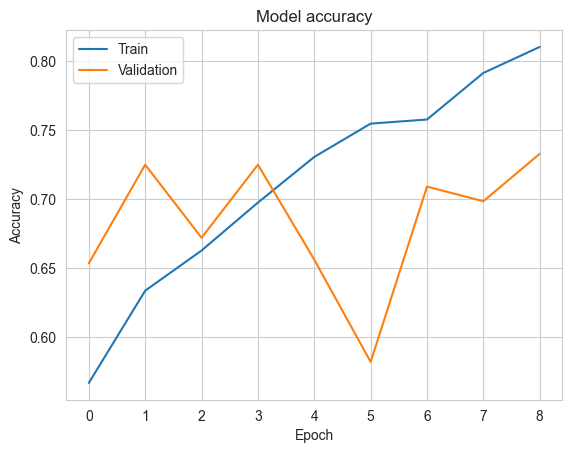

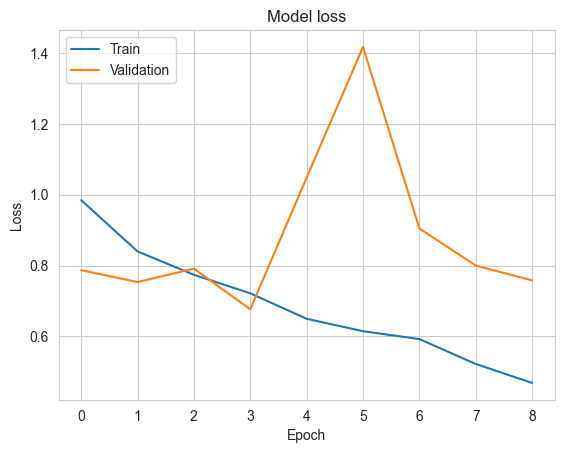

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [39]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(Fore.BLUE + report)

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       126
           1       0.70      0.73      0.72       126
           2       0.58      0.73      0.65       126

    accuracy                           0.67       378
   macro avg       0.70      0.67      0.68       378
weighted avg       0.70      0.67      0.68       378



In [40]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

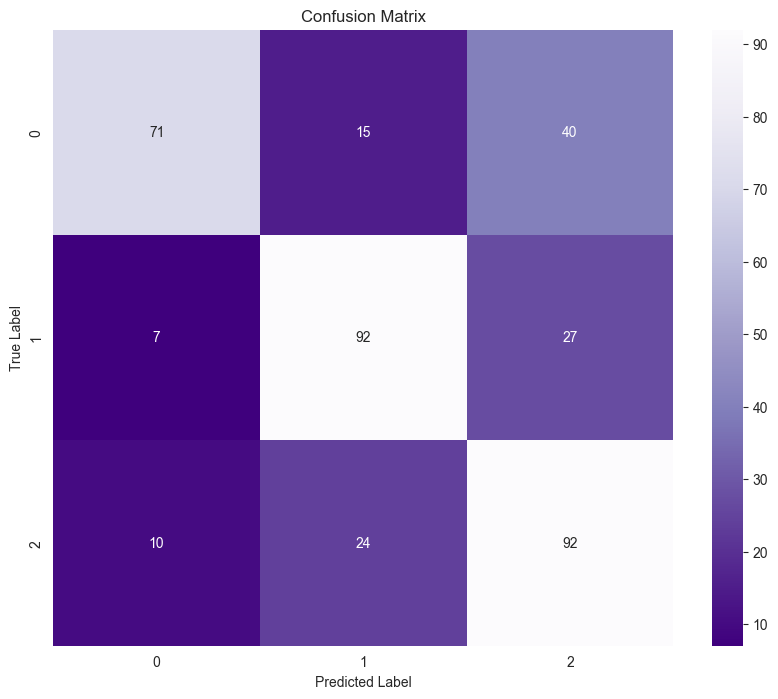

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples_r', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, GaussianNoise, MultiHeadAttention, 
    Reshape, Conv2D, Multiply
)
from tensorflow.keras.optimizers import Adam

In [43]:
def squeeze_and_excitation_block(input_tensor, ratio=16):
   
    channels = input_tensor.shape[-1]  
    se = GlobalAveragePooling2D(name="SE_Squeeze")(input_tensor)
    se = Dense(channels // ratio, activation="relu", name="SE_Excitation_1")(se)
    se = Dense(channels, activation="sigmoid", name="SE_Excitation_2")(se)
    se = Multiply(name="SE_Scale")([input_tensor, se])
    return se

def create_mobilenet_model(input_shape, num_classes=8, learning_rate=1e-4):
    inputs = Input(shape=input_shape, name="Input_Layer")

    base_model = MobileNet(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = False  

    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]

    x = squeeze_and_excitation_block(x)

    x = Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    x = Reshape((height, width, channels), name="Reshape_to_Spatial")(x)
    x = GaussianNoise(0.25, name="Gaussian_Noise")(x)
    x = GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = Dense(512, activation="relu", name="FC_512")(x)
    x = BatchNormalization(name="Batch_Normalization")(x)
    x = Dropout(0.25, name="Dropout")(x)

    outputs = Dense(num_classes, activation="softmax", name="Output_Layer")(x)
    model = Model(inputs=inputs, outputs=outputs, name="MobileNet_with_Attention_SE")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

input_shape = (224, 224, 3)
cnn_model = create_mobilenet_model(input_shape, num_classes=3, learning_rate=1e-4)

C:\Users\HP\AppData\Local\Temp\ipykernel_27348\289096279.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", input_tensor=inputs, include_top=False)


In [61]:
cnn_model.summary()

Model: "MobileNet_with_Attention_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ Input_Layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 105,948,555 (404.16 MB)

 Trainable params: 34,239,555 (130.61 MB)

 Non-trainable params: 3,229,888 (12.32 MB)

 Optimizer params: 68,479,112 (261.23 MB)

In [44]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 184s 931ms/step - accuracy: 0.5758 - loss: 1.0873 - val_accuracy: 0.6534 - val_loss: 0.8859
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 173s 914ms/step - accuracy: 0.6759 - loss: 0.7760 - val_accuracy: 0.6164 - val_loss: 1.1222
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 904ms/step - accuracy: 0.7173 - loss: 0.6772 - val_accuracy: 0.6534 - val_loss: 0.8592
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 171s 907ms/step - accuracy: 0.7654 - loss: 0.5692 - val_accuracy: 0.7275 - val_loss: 0.6660
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 172s 907ms/step - accuracy: 0.7940 - loss: 0.5016 - val_accuracy: 0.6667 - val_loss: 0.8454
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 173s 915ms/step - accuracy: 0.8447 - loss: 0.4140 - val_accuracy: 0.7407 - val_loss: 0.7440
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 177s 934ms/step - accuracy: 0.8702 - loss: 0.3396 - val_accuracy: 0.7116 - val_loss: 1.0172
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 178s 943ms/step - accuracy: 0.8983 -

In [45]:
y_pred = cnn_model.predict(valid_gen_new)  
y_true = valid_gen_new.labels

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step


In [46]:
ppo_loss_value = ppo_loss(y_true, y_pred)
print(Fore.RED + "PPO Loss on Validation Data:", ppo_loss_value.numpy())

PPO Loss on Validation Data: -1.0


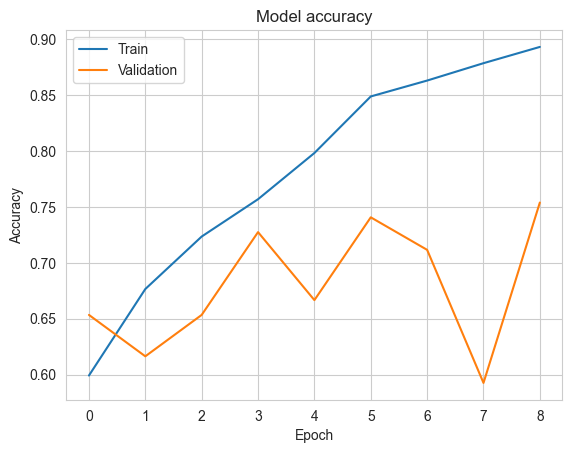

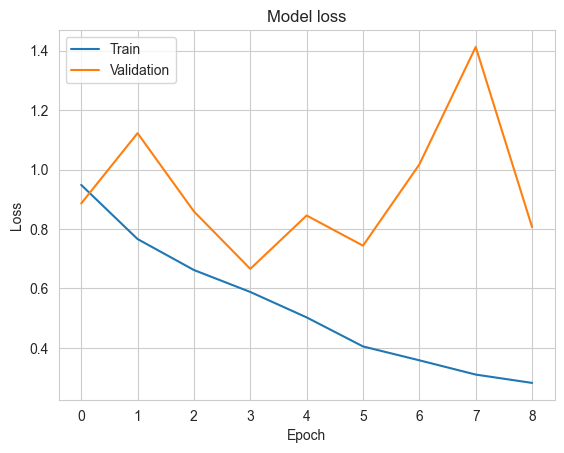

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step


In [49]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(Fore.GREEN + report)

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       126
           1       0.66      0.78      0.72       126
           2       0.79      0.50      0.61       126

    accuracy                           0.70       378
   macro avg       0.71      0.70      0.69       378
weighted avg       0.71      0.70      0.69       378



In [50]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

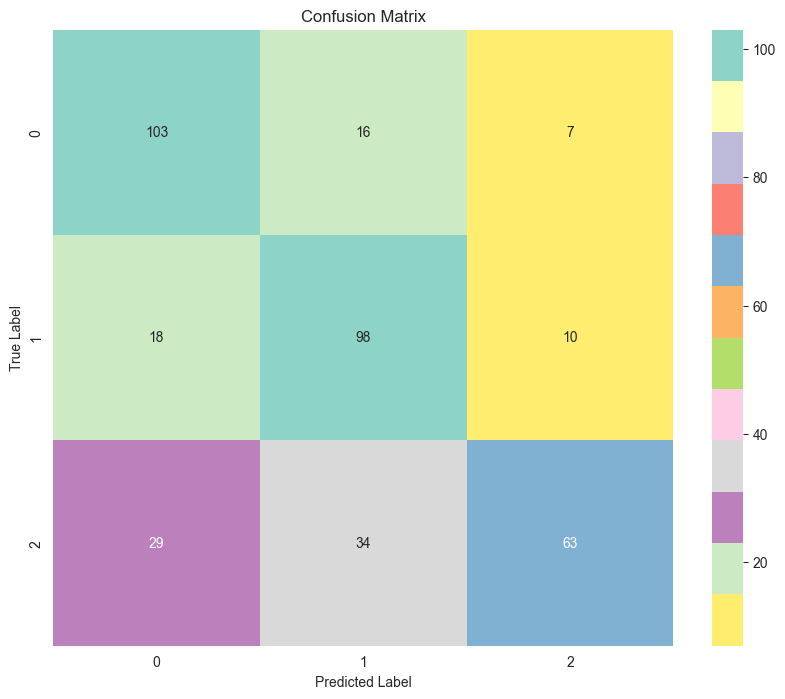

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Set3_r', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()